# Variational Inference for Univariate Gaussian Mixtures

### Table of Contents

1. [Introduction](#Introduction)
2. [Simulating a Univariate Gaussian Mixture Prior](#Simulating-a-Univariate-Gaussian-Mixture-Prior)
3. [Coordinate Ascent](#Coordinate-Ascent)



## Introduction

In this tutorial, we will implement variational Inference for estimation of univariate gaussian mixtures. **Univariate Gaussian Mixture** is essentially a mixture of *N* 1-dimensional Gaussian distributions. The problem is: given a dataset of gaussian mixtures, how can we estimate the Mean and Standard Deviation of each of the normal distributions within the data. how do we even approach this problem?

If the reader is familiar with basic Machine Learning algorithms, then the problem might be more digestible by thinking about it as a clustering problem. If we consider each of the gaussians within our mixture as a globular cluster then we might be able to run a clustering algorithm such as KMeans to obtain the cluster centers, which translate to the means of our gaussians.

Variational Inference (VI) for this problem can be seen as a generalization of the KMeans algortihm. VI, In essence, it is a Bayesian Optimization method. In Bayesian Optimization, we assume that our data is sampled from some prior distribution. The assumption allows us us to initialize a model (statistical distribution) of the data such that we can iteratively update the parameters of the model ( variational parameters ) to converge to the underlying data distribution. At the end of convergence, the model ( the posterior distribution ) should be such that sampling from it will have the highest likelihood of generating the observed data.

The work has been inspired by the brilliant blog post of Lei Mao. Go check out his [blogs](https://leimao.github.io/)! He has basically derived nearly the entirety of the math for VI  on Univariate Gaussian Mixture Models. His blog post (check references down below) contains a comprehensive introductory reading into the theory of VI. This post simply covers the algorithm portion of it. I would highly recommend reading his derivations end to end.

In [ ]:
!pip install pomegranate

Here we import all the libraries we will need. Note that the gaussian mixtures in this post have been generated with a nifty little library called ***pomegranate*** . It is a python package that allows us to create probability distributions (such as gaussian mixture models) and sample from them. It can also do a bunch of cool stuff like bayesian estimation of distributions from observed data, hidden markov models, etc. Ironically, bayesian estimation is exactly what we will be doing today.

In [2]:
from pomegranate import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Optional, Union, Tuple

In [3]:
# To enable type hinting for all subsequent functions
DF = pd.DataFrame
NP = np.ndarray

## Simulating a Univariate Gaussian Mixture Prior

In [3]:
# Each entry in prior gaussians sets up a cluster center followed by the cluster standard deviation
prior_gaussians = [ 
    [-10,1],
    [0,1],
    [10,1]
]

dist_list = []

for k in prior_gaussians:
    dist_list.append(NormalDistribution(k[0],k[1]))

# Use GeneralMixtureModel in the pomegranate library to create a combined distribution
# from the individual Normal Distributions.
# The combined model is equivalent to a Gaussian Mixture model with as many Gaussaians as
# there are cluster centers
gaussian_mixture_model = GeneralMixtureModel(dist_list)

In the above code, initialize a mixture of gaussians with 3 cluster centers. We start simple by assuming the standard deviation for all of these gaussians is 1. The means of the gaussians are -10, 0, & 10. We define the `prior_gaussians` variable accordingly. 

Next we create the `gaussian_mixture_model` variable as shown above. 

Let us see if our mixture model looks okay.

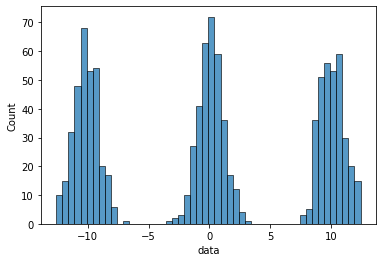

In [4]:
# Sample Data from the Gaussian Mixture model
data=pd.DataFrame(gaussian_mixture_model.sample(1000),columns=['data'])

# Visualize the distribution to make sure we are sampling data as expected
sns.histplot(data,x='data',bins=50)
plt.show()

In the code above, we have sample 1000 points from the mixture model and assigned them to our observed data-set. In a bayesian optimization setting, note that our models only have access to the observed data, but never the underlying distribution that generated the dataset. Out task in the bayesian framework is to assume a prior model and estimate the parameters of that model in order to "recreate" the distribution that generated our observed dataset.

--------------

## Coordinate Ascent

Now let us review the psuedo-code from Blei et. al. that describes the inference procedure for coordinate ascent. Before we do, note that there are a number of ways of doing parameter estimation for Bayesian inference such as *Markov Chain Monte Carlo*, *Expectation Maximization (EM)*, and *coordinate ascent*. The Coordinate Ascent (CA) algorithm is similar to EM algorithm in the sense that it iteratively updates variational parameters and latent variables of a model. In the CA procedure, we initialize the parameters and latent variables of a prior family of distributions that we want to estimate. Then, according to an update formula, we update the parameters & latent variables. In this case, the update formulae come pre-formulated to us thanks to Lei Mao's blog post and Blei at. al. (check references below).


So instad of deriving the math, let us build an intuition for what is going on.

![Psuedo-code for coordinate ascent](../../assets/VI_coord_ascent_gaussian_psuedo_code.png)

<p style="text-align: center;">Variational Inference for Gaussian Mixtures using Coordinate Ascent (Blei et. al.)</p>

![Psuedo-code for coordinate ascent](../../assets/phi_update.png)

<p style="text-align: center;">Cluster assignment variational parameter update equation (Lei Mao)</p>

In [7]:
class univariate_gaussian_variational_inference(object):
    def __init__(self,data:NP,K:int)->None:
        
        if not isinstance(data, NP) or len(data.shape)>1:
            raise Exception("Input Data MUST be a 1 dimensional numpy array")
            
        self.data=data
        self.k=K
        self.num_samples=data.shape[0]
        self.cluster_assignments=None
        
    def init_variational_params(self)->Tuple[NP,NP,NP]:
        # Initialize Variational Parameters
        
        # For the m parameter, a reasonable initialization is 
        # finding the limits of the data and sampling from a 
        # uniform distribution within that range
        data_range = (min(self.data),max(self.data))
        m = np.random.uniform(low=data_range[0],high=data_range[1],size=self.k)
        
        # For the S variational param, leave all standard deviations as one
        var = np.ones(self.k).astype(float) ** 2 # adding the square just to make sure we know what this variable is later
        
        # For the phi latent variable
        # initialize an N x K matrix
        # then population the matrix with random probabilities
        # each row sums to 1
        phi = np.random.uniform(low=0,high=1,size=[len(data),self.k])
        phi = phi/phi.sum(axis=1,keepdims=True)
        
        return (m,var,phi)
        
    def coordinate_ascent_optimizer(self,num_iters:int=1000)->Tuple[NP,NP,NP]:
        m,var,phi = self.init_variational_params()
                
        # For the first implementation, we don't compute ELBO
        # We simply run the algorithm for N iterations
        for _ in range(num_iters):
            for i in range(len(self.data)):
                phi[i,:] = np.exp(m*self.data[i] - ((var + m**2)/2))
                phi[i,:] = phi[i,:] / phi[i,:].sum()
                
            # Now let us assume that the prior variance of component means is 1
            # then
            for k in range(self.k):
                m[k] = np.sum(phi[:,k] * self.data)/(1 + np.sum(phi[:,k]))
                var[k] = 1 / (1 + np.sum(phi[:,k]))
            
        self.cluster_assignments = np.argmax(phi,axis=1)
        
        return m,var,phi

Let us initialize the variational inference object

In [53]:
vi=univariate_gaussian_variational_inference(data['data'].values,3)

Now running the algorithm for 0 iterations will simply initialize the variational parameters. That means the cluster probability densities will have a random initialization. So in theory all of our data points should have random cluster assignments. Let's test this hypothesis

In [55]:
_=vi.coordinate_ascent_optimizer(0)
data['cluster']=vi.cluster_assignments

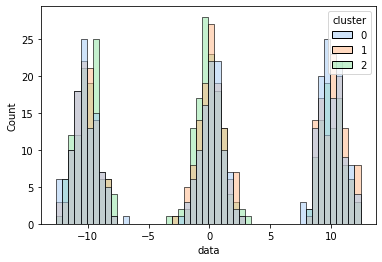

In [56]:
sns.histplot(data,x='data',hue='cluster',bins=50, alpha=0.5, palette='pastel')
plt.show()

From the above plot, it is quite clear that the distribution of clusters is jumbled up, with points being randomly assigned to each cluster with a roughly uniform likelihood. 

Now let us run the algorithm for just 1 iteration

In [57]:
_=vi.coordinate_ascent_optimizer(1)
data['cluster']=vi.cluster_assignments

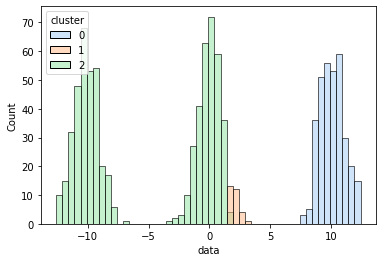

In [58]:
sns.histplot(data,x='data',hue='cluster',bins=50, alpha=0.5, palette='pastel')
plt.show()

It seems like the algorithm has already learned some distinctions between the decision boundaries. But the algorithm has obviously not converged. Let us run for 10 more iterations

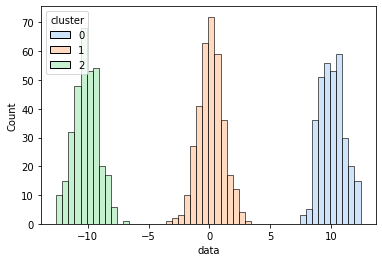

In [59]:
_=vi.coordinate_ascent_optimizer(10)
data['cluster']=vi.cluster_assignments

sns.histplot(data,x='data',hue='cluster',bins=50, alpha=0.5, palette='pastel')
plt.show()

Voila! The algorithm has converged in just 10 iterations. Now, let us do some experiments to test the limits of this algorithm. 

## Clusters with different variances

The original dataset comes from 3 normal distributions with a constant standard deviation ( of 1 ). What would happen if the data has cluster with variable standard deviations? 

1. Can we recover the clusters in the same way?
2. Will the estimated variational parameter recover the prior standard deviation?

Let us test. First we will take a similar approach to set up the input dataset with just different vairances

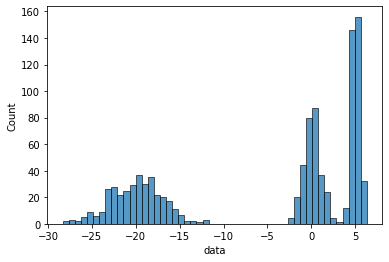

In [5]:
prior_gaussians = [ 
    [-20,3],
    [0,1],
    [5,0.5]
]

dist_list = []

for k in prior_gaussians:
    dist_list.append(NormalDistribution(k[0],k[1]))

gaussian_mixture_model = GeneralMixtureModel(dist_list)
data=pd.DataFrame(gaussian_mixture_model.sample(1000),columns=['data'])

sns.histplot(data,x='data',bins=50)
plt.show()

Let us run the algorithm for 3 iterations first

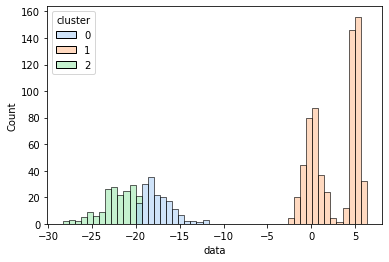

In [10]:
vi=univariate_gaussian_variational_inference(data['data'].values,3)
_=vi.coordinate_ascent_optimizer(3)
data['cluster']=vi.cluster_assignments

sns.histplot(data,x='data',hue='cluster',bins=50, alpha=0.5, palette='pastel')
plt.show()

Not quite there. Let's run it for 50 iterations

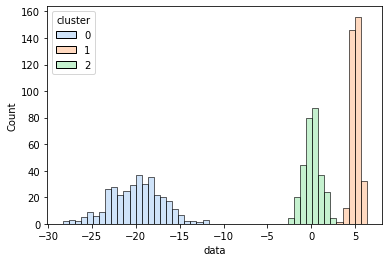

In [11]:
m,var,phi=vi.coordinate_ascent_optimizer(50)
data['cluster']=vi.cluster_assignments

sns.histplot(data,x='data',hue='cluster',bins=50, alpha=0.5, palette='pastel')
plt.show()

Visually it seems like the algorithm has recovered the clusters. Now let us examine the variational parameters

In [15]:
print('Cluster means & variance obtained from coordinate ascent optimization')
print(list(zip(m.round(2),np.sqrt(var).round(4))))

Cluster means & variance obtained from coordinate ascent optimization
[(-19.93, 0.0531), (4.98, 0.0535), (0.07, 0.0578)]


That's very interesting, it is clear that the cluster means are about the correct values but standard deviation is not converging to the values we expect. In next updates, we will try to find out why this lack of convergence occurs

## References

[Introduction to Variational Inference](https://leimao.github.io/article/Introduction-to-Variational-Inference/) - Lei Mao, Sr. DL Engineer, NVIDIA, Santa Clara

[Variational Inference: A Review for Statisticians](https://arxiv.org/abs/1601.00670) - Blei et. al.